## building basic chatbot

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
graph_builder = StateGraph(State)

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq

In [7]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_KEY")

In [9]:
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
)

In [14]:
## Node Functionality
def chatbot(state:State):
    return {
        "messages" : [llm.invoke(
            state['messages']
        )]
    }

In [19]:
if "chatbot" not in graph_builder.nodes:
    graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


In [20]:
graph = graph_builder.compile()

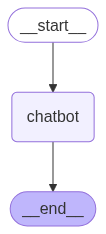

In [22]:
## Visualize 
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [25]:
response = graph.invoke({
    "messages" : "HI"
})

In [29]:
response["messages"][-1].content

'Hello! How can I assist you today? 😊'

In [33]:
for event in graph.stream(
    {"messages" : "hi how are u, and who are u"}
):
    for value in event.values():
        print(value['messages'][-1].content)

Hi! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. I'm an AI created by DeepSeek to assist with answering questions, providing information, and helping with tasks. How can I assist you today? 😊


## chatbot with Tool

In [34]:
load_dotenv()

True

In [ ]:
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_KEY')

In [39]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("what is KamKalima")

{'query': 'what is KamKalima',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Kamkalima | Reviews 2025: Features, Price, Alternatives',
   'url': 'https://edtechimpact.com/products/kamkalima/',
   'content': 'Kamkalima is an innovative digital platform designed to enhance Arabic language learning for students. It provides a comprehensive suite of tools and resources tailored to meet the needs of both educators and learners. By integrating technology with traditional teaching methods, KamKalima aims to make Arabic language education more engaging and effective. One of the standout aspects of',
   'score': 0.92442214,
   'raw_content': None},
  {'title': 'Kamkalima - Classlink Integration Guide',
   'url': 'https://support.kamkalima.com/kamkalima-classlink-integration-guide',
   'content': 'Kamkalima is an Arabic educational platform for learning and teaching in schools. We empower Arabic classrooms with the needed tools, resources, and support to r

In [71]:
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of the two integers.
    """
    return a + b

def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The multiplication of the two integers.
    """
    return a * b


In [72]:
tools = [tool, add, multiply]

In [73]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B1386708F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B138670C80>, model_name='deepseek-r1-distill-llama-70b', temperature=1e-08, reasoning_format='parsed', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array

In [74]:
# Stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [75]:
## Node Definiton 
def chatbot_tool_calling(state:State):
    return {
        "messages" : [llm_with_tools.invoke(state['messages'])]
    }

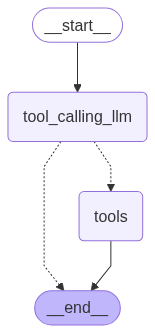

In [83]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [84]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [85]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": ["https://autogpt.net/wp-content/uploads/2023/07/Pogla_Explore_the_latest_AI_news_from_groundbreaking_drug_trial_07ab875d-1e11-42d5-89ef-39ff3d5ab451.jpg", "https://assets.weforum.org/editor/Ktdhn0KNfhbpY_AE77yZFRYJ9zUl9hnFcncbE53QzUQ.PNG", "http://www.marktechpost.com/wp-content/uploads/2023/04/future-artificial-intelligence-robot-network-system-background-scaled.jpg", "https://www.solulab.com/wp-content/uploads/2024/01/Top-Artificial-Intelligence-Trends.jpg", "https://statusneo.com/wp-content/uploads/2023/04/MicrosoftTeams-image.jpg"], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\\\_will continue the conversation on meaningful AI innovations at our AI Imp

In [86]:
for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (mf61mnn06)
 Call ID: mf61mnn06
  Args:
    include_images: True
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": ["https://autogpt.net/wp-content/uploads/2023/07/Pogla_Explore_the_latest_AI_news_from_groundbreaking_drug_trial_07ab875d-1e11-42d5-89ef-39ff3d5ab451.jpg", "https://assets.weforum.org/editor/Ktdhn0KNfhbpY_AE77yZFRYJ9zUl9hnFcncbE53QzUQ.PNG", "http://www.marktechpost.com/wp-content/uploads/2023/04/future-artificial-intelligence-robot-network-system-background-scaled.jpg", "https://www.solulab.com/wp-content/uploads/2024/01/Top-Artificial-In

In [87]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (3p77r573q)
 Call ID: 3p77r573q
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [ ]:
response=graph.invoke({"messages":"what is 5*2 ? and then multiply by 7"}) # the agent will failed to do the second part 
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 5*2 ? and then multiply by 7
================================== Ai Message ==================================
Tool Calls:
  multiply (1ve2adrhn)
 Call ID: 1ve2adrhn
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


## ReAct Agent

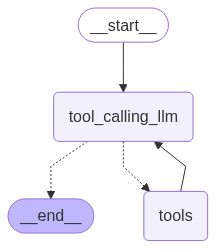

In [92]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)

builder.add_edge("tools", "tool_calling_llm")
## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
response=graph.invoke({"messages":"what is 5*2 ? and then multiply by 7"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 5*2 ? and then multiply by 7
================================== Ai Message ==================================
Tool Calls:
  multiply (czr7ebk1a)
 Call ID: czr7ebk1a
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================
Tool Calls:
  multiply (bb4xjc6nb)
 Call ID: bb4xjc6nb
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================
Tool Calls:
  multiply (72dxkzr2k)
 Call ID: 72dxkzr2k
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================
Tool Calls:
  

In [94]:
response=graph.invoke({"messages":"Do you my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Do you my name
================================== Ai Message ==================================

I don't have access to your personal information, including your name. If you'd like, you can share it with me, and I'll be happy to assist you further! How can I help you today?


## Agent with Memory

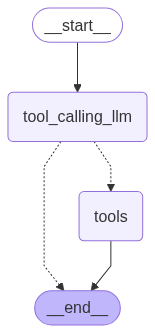

In [97]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is ALI"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi my name is ALI
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6y11gny3t)
 Call ID: 6y11gny3t
  Args:
    exclude_domains: None
    include_domains: None
    include_images: None
    query: ALI
    search_depth: basic
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "ALI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Muhammad Ali - Wikipedia", "url": "https://en.wikipedia.org/wiki/Muhammad_Ali", "content": "Soon after the Liston fight, Clay changed his name to Cassius X, and then later to Muhammad Ali upon converting to the Nation of Islam. In speaking of the cost on Ali's career of his refusal to be drafted, his trainer Angelo Dundee said, \"One thing must be taken into account when talking about Ali: H

In [100]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"what is my name"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi my name is ALI
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6y11gny3t)
 Call ID: 6y11gny3t
  Args:
    exclude_domains: None
    include_domains: None
    include_images: None
    query: ALI
    search_depth: basic
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "ALI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Muhammad Ali - Wikipedia", "url": "https://en.wikipedia.org/wiki/Muhammad_Ali", "content": "Soon after the Liston fight, Clay changed his name to Cassius X, and then later to Muhammad Ali upon converting to the Nation of Islam. In speaking of the cost on Ali's career of his refusal to be drafted, his trainer Angelo Dundee said, \"One thing must be taken into account when talking about Ali: H

## Streaming in langgraph

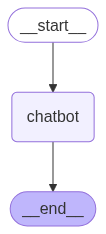

In [104]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("chatbot",chatbot)

## Add Edges
builder.add_edge(START, "chatbot")

builder.add_edge("chatbot",END)

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [105]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hello"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today? 😊


Methods: .stream() and astream()

    These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

    values : This streams the full state of the graph after each node is called.
    updates : This streams updates to the state of the graph after each node is called.


In [112]:
config = {"configurable": {"thread_id": "4"}}

for chunk in graph.stream({'messages':"Hi,My name is Ali Assi And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content="Hi Ali! It's great to meet you. Cricket is such an exciting sport—do you have a favorite team or player you support? I'd love to hear more about what you enjoy most about the game!", additional_kwargs={'reasoning_content': "Okay, so I just met someone named Ali Assi who likes cricket. I want to respond in a friendly and engaging way. First, I should acknowledge his name and his interest. Maybe start with a greeting and express that it's nice to meet him. Then, I can ask him a bit more about his interest in cricket to keep the conversation going. I should keep it casual and open-ended so he feels comfortable sharing more. Maybe ask which team he supports or who his favorite player is. That way, I can learn more about his interests and perhaps find some common ground. I should also make sure my response is positive and enthusiastic to show genuine interest.\n"}, response_metadata={'token_usage': {'completion_tokens': 181, 'prompt_tokens': 15, 

In [114]:
config = {"configurable": {"thread_id": "5"}}

for chunk in graph.stream({'messages':"Hi,My name is Ali And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Ali And I like cricket', additional_kwargs={}, response_metadata={}, id='ec1500ab-6cc3-490d-b743-bb48b0943c67')]}
{'messages': [HumanMessage(content='Hi,My name is Ali And I like cricket', additional_kwargs={}, response_metadata={}, id='ec1500ab-6cc3-490d-b743-bb48b0943c67'), AIMessage(content="Hi Ali! It's great to meet you. Cricket is such an exciting sport—do you have a favorite team or player you always support?", additional_kwargs={'reasoning_content': "Okay, so I just met someone named Ali who likes cricket. I want to respond in a friendly and engaging way. First, I should acknowledge his name and his interest. Maybe start with a greeting and express that it's nice to meet him. Then, I can ask him a question about cricket to keep the conversation going. I should think about what aspects of cricket someone might be interested in—like their favorite team, player, format of the game, or maybe a memorable match they've watched. I don'

In [127]:
from langchain_core.messages import AIMessageChunk
reasoning_phase = True
separator_printed = False
config = {"configurable": {"thread_id": "7"}}

async for event in graph.astream_events({"messages":["i love football"]}, config, version="v2"):
    if event.get('event') == 'on_chat_model_stream':
        chunk = event.get('data', {}).get('chunk')
        
        if isinstance(chunk, AIMessageChunk):
            reasoning = chunk.additional_kwargs.get('reasoning_content', '')
            content = chunk.content
            
            if reasoning and reasoning_phase:
                # We're in reasoning phase
                print(reasoning, end='')
            elif content and reasoning_phase:
                # Transition from reasoning to content
                if not separator_printed:
                    print("\n" + "-" * 80 + "\n")
                    separator_printed = True
                    reasoning_phase = False
                print(content, end='')
            elif content and not reasoning_phase:
                # Continue with content
                print(content, end='')

Alright, the user just said, "i love football." Let me see. Earlier, they mentioned their name is Ali and they like cricket. Now they're expressing love for football. Hmm, so they enjoy two sports. I should acknowledge both interests.

I want to make sure they feel heard. Maybe I can ask which one they prefer or if they play either. That way, the conversation stays engaging. I should keep it friendly and open-ended to encourage them to share more.

--------------------------------------------------------------------------------

That's awesome, Ali! Football is such a thrilling sport with so much energy and teamwork. Do you have a favorite football team or player? Or do you prefer playing the game yourself?